<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/010_LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

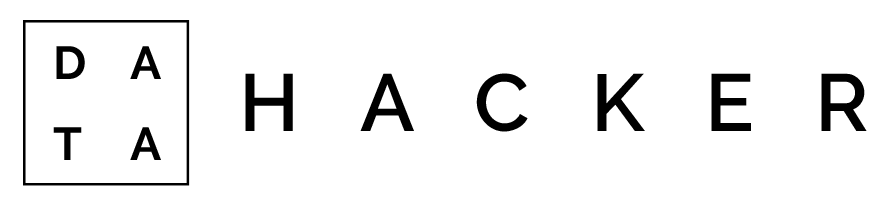
# LeNet

LeNet-5 Is a foundamental Convolutional Neural Network. We will see a bit of theory and also how to implement it using PyTorch.

The main goal of LeNet-5 was to recognize handwritten digits. 

It was invented by Yann LeCun in 1998 and was the first Convolutional Neural Network.

It takes as an input a 32x32x1 image, that is grayscaled and outputs a predictions.

Let's take a look at the architecture of this neural network.

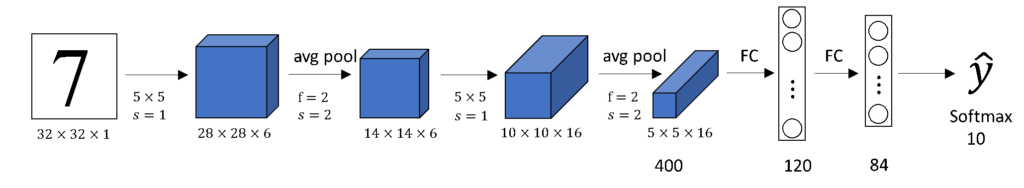

Layer 1 (C1): First convolutional layer with 6 kernels of size (5x5) and stride of 1. The input size to this layer is (32x32x1) and the output is of size (28x28x6).

Layer 2 (S2): Pooling layer with 6 kernels of size(2x2) and stride of 2. The output of this layer is of size (14x14x6)

Layer 3 (C3): Another convolutional layer, same configurations, just with 16 filters. Output is of size (10x10x16)

Layer 4 (S4): Pooling layer, again with the same configurations as the previous, just with 16 filters. Output is (5x5x16)

Layer 5 (F5): First fully-connected layer. It returns 120 units, and the activation function will the tanh activation function.

Layer 6 (F6): Second fully-connected layer. It takes 120 units and returns 84, and for the activation function we will use the softmax function.

Let's understand the parameters a bit.
>The kernel size basically defines the size of the convolutional filters.

>The stride parameter is an integer value, specifying the step of the convolution along the height and width of the input

Now, that we know a bit of theory behing the LeNet-5 network, we can start building it. We first import all the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

We will define a variable `devices` which will store 'cpu' or 'gpu' depending on what we are training on.

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In this step we will download the necessary dataset for training and validation. 

I will not get in much detail here, i will just go through the code. If you want to learn more about data loaders, we covered this topic in a previous video. I will leave a link in the description bellow.


Moving on, we will download the fashion-MNIST dataset. We resize our images so that they are (32x32) and then convert them to tensors, this will automatically scale our images to the [0, 1] range. We also specify the batch size to be `64` and we also shuffle our data.

In [ ]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

Extract one batch from the training set, and if we check out the shape, we see that we have 64 images that are of shape (1x32x32) and also 64 labels.

In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape) # Size of the image
print(labels.shape) # Size of the labels

torch.Size([64, 1, 32, 32])
torch.Size([64])


Now, the interesting stuff. Building the LeNet5 model. We start by defining a class `LeNet5` and we define a `__init__` function. 

The easiest and most elegant way to create this model is by splitting the convolutional and linear layers. We can do this by creating two sequential models, one will be called `self.convolutional_layer` and the second `self.linear_layer`. For the convolutional layer we will create 3 convolutional layers and 2 average pooling layers, with 3 activation functions.

For the `linear_layer` we will define two linear layers and the activation function after the first will be a `tanh` function. For the softmax function we will apply it in the forward function directly.

In the forward function, we first call the `self.convolutional_layer` on the image, than we flatten the result and pass it into the `self.linear_layer`, and on the result from the linear layer we apply the softmax.

In [ ]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.convolutional_layer = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x

Call the model we just created and set it to work on the device we defined in the beggining

In [ ]:
model = LeNet5().to(device)
print(model)

LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


For the optimizer we use `Adam` and for the loss `CrossEntropyLoss`

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

The training is the same as usual, so i will not get in deep details here. We will train it for 20 iterations. We iterate through all training images and set them to work with the device we specified in the beggining. Zero the gradients, do the forward propagation, calculate the loss and do the backpropagation step. After the training step we will do the evaluation step as usual. We iterate throught all the testing images and use our model for predictions. We add 1 every time our model predicts correctly and we use this for calculating the accuracy. We will print every 5th epoch, the training loss, validation loss and validation accuracy

In [ ]:
epochs = 20
train_loss, val_loss = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    # training our model
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / test_data_size

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, accuracy))


Epoch: 0/20, Train Loss: 1.7329, Val Loss: 1.6681, Val Acc: 0.7958

Epoch: 5/20, Train Loss: 1.5952, Val Loss: 1.6102, Val Acc: 0.8506

Epoch: 10/20, Train Loss: 1.5742, Val Loss: 1.5933, Val Acc: 0.8680

Epoch: 15/20, Train Loss: 1.5644, Val Loss: 1.5897, Val Acc: 0.8701


To get a better understanding of how our model did, we will plot the training  and validation loss.

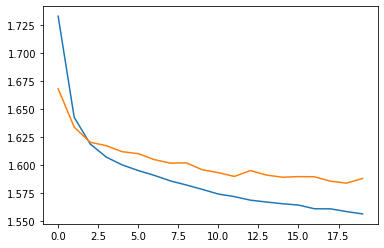

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)

Also, we will extract one batch from the testing set and get the images and labels from that batch.

In [ ]:
testiter = iter(testloader)
images, labels = testiter.next()

We then use our model to predict on that batch or those 64 images 

In [ ]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

We extract all the images into a list using this one line for loop. We convert the data to numpy. Create a list of classes, that can be found on the internet.

In [ ]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We iterate through 50 images and plot them with their corresponding label. We will color the label in `blue` if our model guessed correct and in `red` if it failed to predict that class.

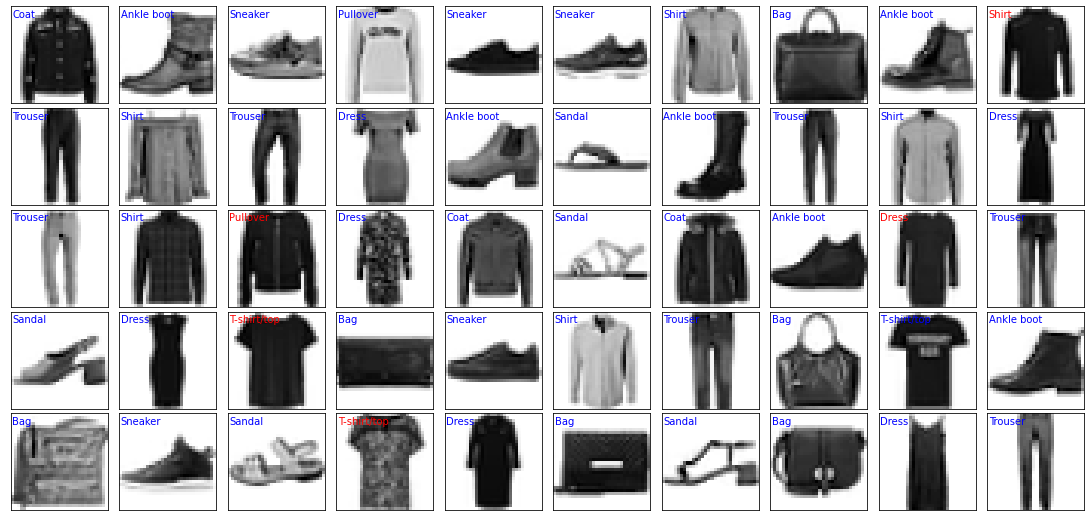

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')